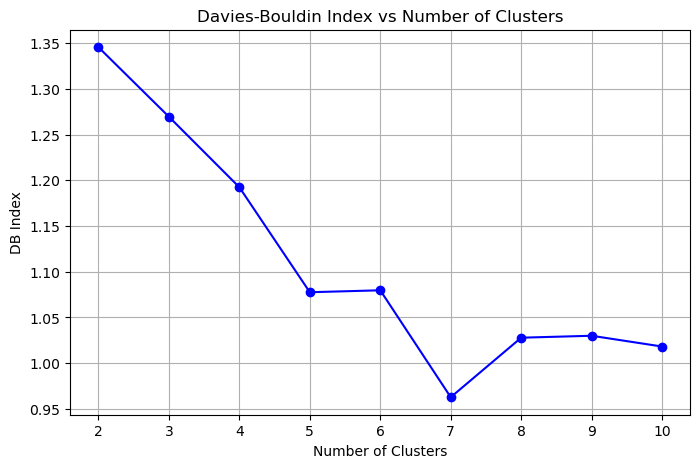

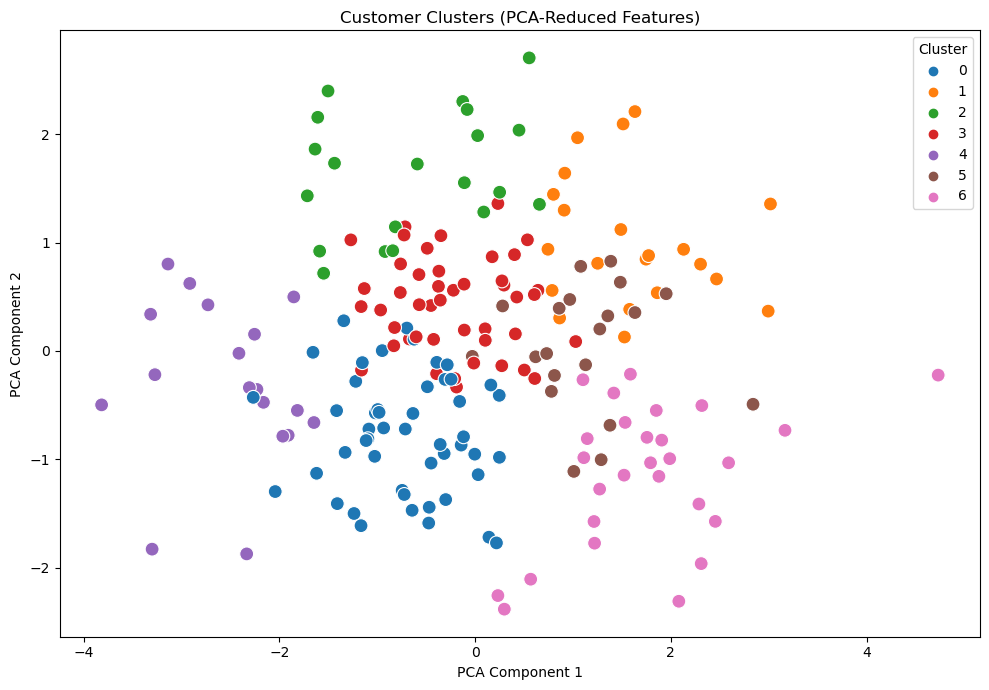

Cluster Summary:
   Cluster  total_customers  avg_revenue  avg_transaction_count  \
0        0               49  2427.527959               4.040816   
1        1               21  5741.905714               6.714286   
2        2               20  2404.900500               2.500000   
3        3               45  3114.695556               5.444444   
4        4               18   666.914706               2.294118   
5        5               20  4907.911000               5.000000   
6        6               27  5655.984815               8.407407   

   avg_days_since_signup  
0             858.551020  
1             211.333333  
2             262.050000  
3             273.533333  
4             495.611111  
5             814.450000  
6             824.518519  
Optimal Number of Clusters: 7
Davies-Bouldin Index for Optimal Clusters: 0.9626325835612756


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load Datasets
customers = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\data science\Customers.csv")
transactions = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\data science\Transactions.csv")

# Merge Datasets
customer_transactions = transactions.groupby('CustomerID').agg(
    total_revenue=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Feature Engineering
customer_data['days_since_signup'] = (
    pd.Timestamp.now() - pd.to_datetime(customer_data['SignupDate'])
).dt.days

# Selecting Features for Clustering
features = customer_data[['total_revenue', 'avg_transaction_value', 'transaction_count', 'days_since_signup']]

# Fill missing values with 0 (if any)
features = features.fillna(0)

# Normalize Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering with K-Means
cluster_range = range(2, 11)
db_indices = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_indices.append(db_index)

# Optimal Number of Clusters
optimal_k = cluster_range[np.argmin(db_indices)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Davies-Bouldin Index Plot
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_indices, marker='o', color='b')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(cluster_range)
plt.grid()
plt.show()

# Visualizing Clusters with PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
customer_data['PCA1'] = reduced_features[:, 0]
customer_data['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100
)
plt.title("Customer Clusters (PCA-Reduced Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Cluster Insights
cluster_summary = customer_data.groupby('Cluster').agg(
    total_customers=('CustomerID', 'count'),
    avg_revenue=('total_revenue', 'mean'),
    avg_transaction_count=('transaction_count', 'mean'),
    avg_days_since_signup=('days_since_signup', 'mean')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)

# Save Cluster Summary as a CSV
cluster_summary.to_csv(r"C:\Users\siddh\OneDrive\Desktop\data science\Siddhartha_LM_Clustering_Summary.csv", index=False)

# Final Report Metrics
final_db_index = min(db_indices)
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index for Optimal Clusters: {final_db_index}")
